**Author:** Moses Uyadi
This notebook cleans the data so that it will be ready for feature selection.
***This script was developed with assistance from ChatGPT (OpenAI, Oct 2025 version).***

# Data Engineer - Cleaning  & Encoding
**This handles the preprocessing for the UNSW-NB15 dataset.**

**Task completed:**
- Merges all dataset parts into one DataFrame
- Drops duplicates and handles missing values
- Encodes categorical feautures using Label Encoding
- Saves the cleaned dataset as "UNSW_NB15_full.csv"
- Visualizes the label distribution

# Step 1: Import required Libraries 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import os

# Step 2: Load and Merge Dataset Parts

In [7]:
df = pd.read_csv('../data/UNSW-NB15_full.csv')
print("Loaded dataset shape:", df.shape)


/var/folders/sf/3m0szrln32z4sksr71t6fmy40000gn/T/ipykernel_1231/792813805.py:1: DtypeWarning: Columns (1,3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/UNSW-NB15_full.csv')


Loaded dataset shape: (2540047, 49)


# Step 3: Drop duplicates and Handle Missing Values 

In [8]:
RAW_PATH = "../data/UNSW-NB15_full.csv"  # <-- change if needed
raw = pd.read_csv(RAW_PATH, low_memory=False)
print("[load] raw shape:", raw.shape)

# If you already have df from earlier and it's empty, overwrite it with fresh data
df = raw.copy()

# --- 1) Replace inf with NaN so fills work; report missingness ---
df.replace([np.inf, -np.inf], np.nan, inplace=True)
na_before = df.isna().sum().sum()
print(f"[na] total NaNs before fill: {na_before:,}")

# --- 2) Split by dtype ---
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# --- 3) Fill missing values (do NOT drop rows) ---
df[cat_cols] = df[cat_cols].fillna("Unknown")

for col in num_cols:
    if df[col].notna().any():
        df[col] = df[col].fillna(df[col].mean())
    else:
        # if a numeric column is entirely NaN, fill 0 as a last resort and log it
        df[col] = df[col].fillna(0)
        print(f"[warn] column '{col}' was all-NaN; filled with 0")

na_after = df.isna().sum().sum()
print(f"[na] total NaNs after fill: {na_after:,}")
print("[shape] after fill:", df.shape)

# --- 4) Remove clearly invalid zero-traffic rows ---
before = df.shape[0]
mask = ~((df["dur"] == 0) & (df["sbytes"] == 0) & (df["dbytes"] == 0))
df = df[mask]
removed = before - df.shape[0]
percent = removed / before * 100

print(f"🧭 Removed {removed:,} rows ({percent:.2f}%) where dur, sbytes, and dbytes were all zero.")
print("✅ Final cleaned dataset shape:", df.shape)

# 1) Ensure numeric, just in case
for c in ['dur','sbytes','dbytes']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

print(df[['dur','sbytes','dbytes']].dtypes)

# 2) Count zeros in each column
for c in ['dur','sbytes','dbytes']:
    z = (df[c] == 0).sum()
    print(f"{c} zeros: {z:,}")

# 3) Count rows where all three are zero
all_zero = ((df['dur'] == 0) & (df['sbytes'] == 0) & (df['dbytes'] == 0)).sum()
print(f"rows with dur=sbytes=dbytes=0: {all_zero:,}")

# 4) Peek at a few rows with dur==0 but bytes > 0 (often legit short flows)
sample = df[(df['dur'] == 0) & ((df['sbytes'] > 0) | (df['dbytes'] > 0))].head(5)
print(sample)



[load] raw shape: (2540047, 49)
[na] total NaNs before fill: 4,996,788
[na] total NaNs after fill: 0
[shape] after fill: (2540047, 49)
🧭 Removed 0 rows (0.00%) where dur, sbytes, and dbytes were all zero.
✅ Final cleaned dataset shape: (2540047, 49)
dur       float64
sbytes      int64
dbytes      int64
dtype: object
dur zeros: 8,372
sbytes zeros: 10
dbytes zeros: 500,208
rows with dur=sbytes=dbytes=0: 0
               srcip sport            dstip dsport proto state  dur  sbytes  \
7        10.40.182.3     0      10.40.182.3      0   arp   INT  0.0      46   
10       10.40.170.2     0      10.40.170.2      0   arp   INT  0.0      46   
11       10.40.170.2     0      10.40.170.2      0   arp   INT  0.0      46   
12       10.40.182.3     0      10.40.182.3      0   arp   INT  0.0      46   
221  192.168.241.243   259  192.168.241.243  49320  icmp   URH  0.0    1780   

     dbytes  sttl  ...  ct_ftp_cmd  ct_srv_src  ct_srv_dst ct_dst_ltm  \
7         0     0  ...           0           

# Step 4: Encode Categorical Columns

In [9]:
# Each categorical column gets encoded
for col in cat_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col].astype(str))

print("Categoricaal columns encoded individually.")


Categoricaal columns encoded individually.


# Step 5: Convert and Scale Numeric Data

In [10]:
# Convert numeric-like columns to numbers 
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass  # leave non-numeric/categorical columns as-is

print("Numeric columns converted and ready for scaling.")



Numeric columns converted and ready for scaling.


In [11]:
output_path = "../data/UNSW-NB15_cleaned.csv"
df.to_csv(output_path, index=False)
print(f"Saved cleaned file to: {output_path}")

print("Cleaned dataset shape:", df.shape)

Saved cleaned file to: ../data/UNSW-NB15_cleaned.csv
Cleaned dataset shape: (2540047, 49)


# Step 6: Split Data & Visualize Label Distribution

Saved: ../data/UNSW-NB15_cleaned.csv → (2540047, 49)


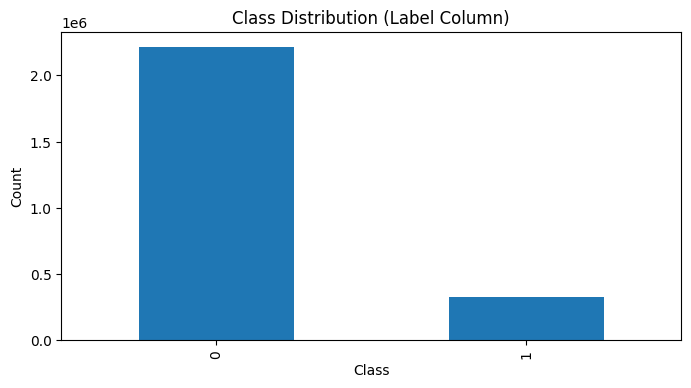

In [14]:
# Identify label column (if it's always last)
label_col = df.columns[-1]  # or explicitly label_col = "label"

# Ensure label is numeric
df[label_col] = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)

# Create cleaned DataFrame (unsplit, unscaled)
df_cleaned = df.copy()

# Save cleaned file to ../data/
from pathlib import Path
DATA = Path("../data")
DATA.mkdir(parents=True, exist_ok=True)
df_cleaned.to_csv(DATA / "UNSW-NB15_cleaned.csv", index=False)
print("Saved:", DATA / "UNSW-NB15_cleaned.csv", "→", df_cleaned.shape)

# Optional: visualize label distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
df_cleaned[label_col].value_counts().plot(kind='bar')
plt.title('Class Distribution (Label Column)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()